In [12]:
import pandas as pd

In [43]:
data = pd.read_csv('metrics.csv')

print(data.head())

         instance            timestamp metric_name     value
0  localhost:9100  2024-12-02 17:38:31   cpu_usage  3.272218
1  localhost:9100  2024-12-02 17:38:36   cpu_usage  3.272218
2  localhost:9100  2024-12-03 17:38:36   cpu_usage  3.272218
3  localhost:9100  2024-12-04 17:47:15   cpu_usage  3.556889
4  localhost:9100  2024-12-04 17:55:35   cpu_usage  3.485778


Check for missing or duplicate rows

In [54]:
# Check column types and data info
print(data.info())

# Check for missing values
print(data.isnull().sum())

# Check for duplicates
print()
print('duplicated values:', data.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   instance     47 non-null     object        
 1   timestamp    47 non-null     datetime64[ns]
 2   metric_name  47 non-null     object        
 3   value        47 non-null     float64       
 4   hour         47 non-null     int32         
 5   day_of_week  47 non-null     int32         
 6   is_weekend   47 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(1), object(2)
memory usage: 2.3+ KB
None
instance       0
timestamp      0
metric_name    0
value          0
hour           0
day_of_week    0
is_weekend     0
dtype: int64

duplicated values: 0


Convert timestamp to Datetime

In [45]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [46]:
# Extract time-based features
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) # monday=0, sunday=6


In [48]:
print(data[['timestamp', 'hour', 'day_of_week', 'is_weekend']].head())


            timestamp  hour  day_of_week  is_weekend
0 2024-12-02 17:38:31    17            0           0
1 2024-12-02 17:38:36    17            0           0
2 2024-12-03 17:38:36    17            1           0
3 2024-12-04 17:47:15    17            2           0
4 2024-12-04 17:55:35    17            2           0


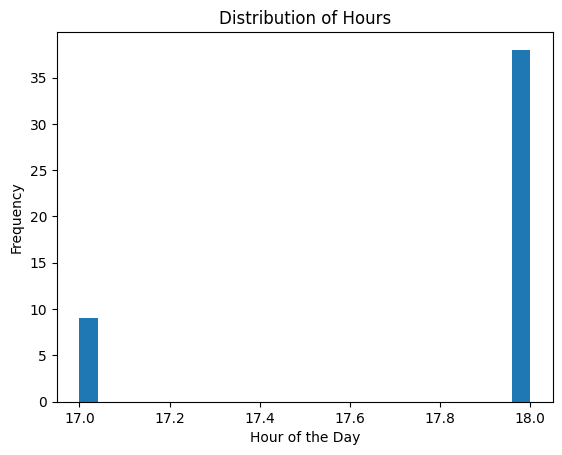

In [49]:
import matplotlib.pyplot as plt

data['hour'].hist(bins=24, grid=False)
plt.title('Distribution of Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.show()


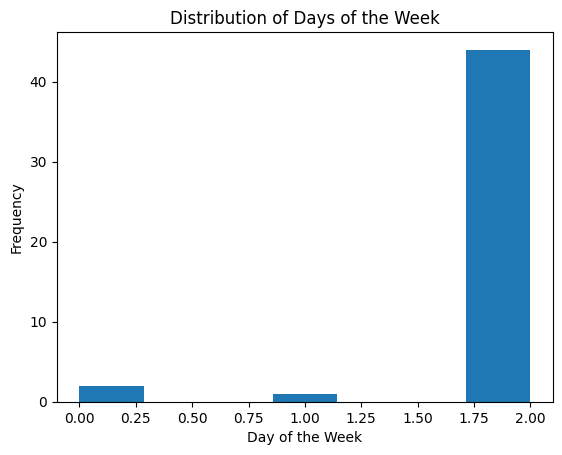

In [50]:
data['day_of_week'].hist(bins=7, grid=False)
plt.title('Distribution of Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.show()